## Load Dataset into the Drive using Kaggle API

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.2/191.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 83.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashukla01","key":"b0652e31cce9e0350fd087c244990d74"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 99% 118M/119M [00:01<00:00, 92.3MB/s]
100% 119M/119M [00:01<00:00, 85.8MB/s]


In [ ]:
! unzip chest-ctscan-images.zip

### Create a new dataset with cancerous and non cancerous images


In [ ]:
! mkdir ct_scan

! mkdir ct_scan/train
! mkdir ct_scan/train/cancerous
! mkdir ct_scan/train/non_cancerous
! cp -r Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. ct_scan/train/cancerous/
! cp -r Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. ct_scan/train/cancerous/
! cp -r Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. ct_scan/train/cancerous/
! cp -r Data/train/normal/. ct_scan/train/non_cancerous/

! mkdir ct_scan/valid
! mkdir ct_scan/valid/cancerous
! mkdir ct_scan/valid/non_cancerous
! cp -r Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/. ct_scan/valid/cancerous/
! cp -r Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/. ct_scan/valid/cancerous/
! cp -r Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/. ct_scan/valid/cancerous/
! cp -r Data/valid/normal/. ct_scan/valid/non_cancerous/

! mkdir ct_scan/test
! mkdir ct_scan/test/cancerous
! mkdir ct_scan/test/non_cancerous
! cp -r Data/test/adenocarcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/large.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/squamous.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/normal/. ct_scan/test/non_cancerous/

In [ ]:
path = "ct_scan/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

ct_scan/train/cancerous
ct_scan/train/non_cancerous


In [ ]:
! rm -R ct_scan/train/.ipynb_checkpoints
! rm -R ct_scan/valid/.ipynb_checkpoints

rm: cannot remove 'ct_scan/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'ct_scan/valid/.ipynb_checkpoints': No such file or directory


In [ ]:
image_paths = ['Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'Data/train/normal',
'Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths = image_paths, n=16):
    # Load the images from disk.
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

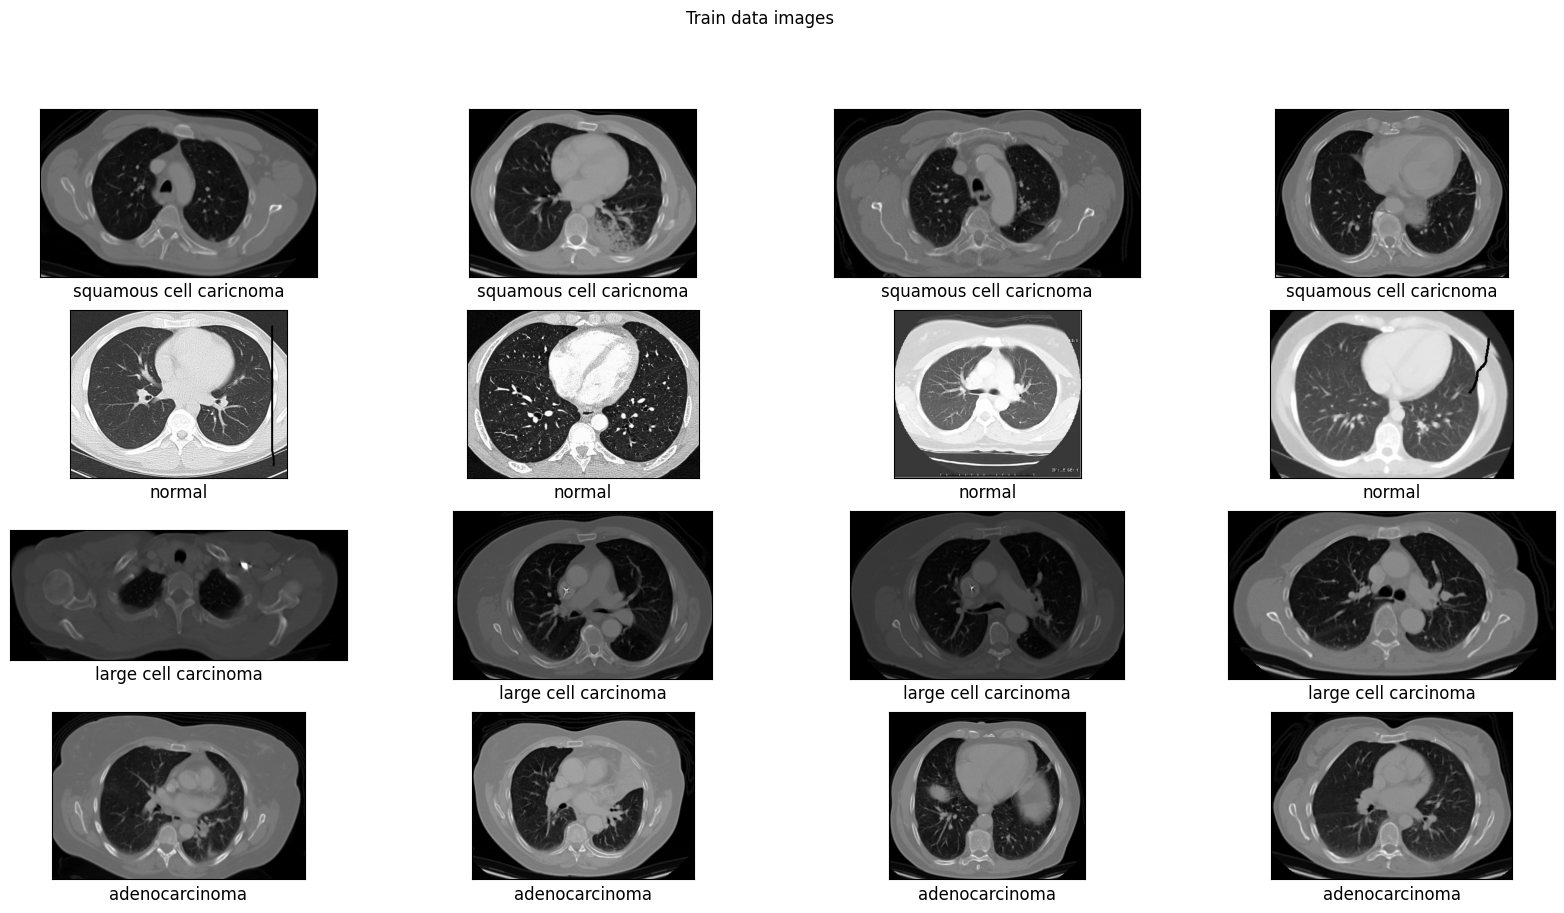

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,10))
l = 1
shapes = []
image_category = ["squamous cell caricnoma", "normal", "large cell carcinoma",  "adenocarcinoma"]
fig.suptitle("Train data images")
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,4,m+l,xticks = [], yticks = [])
        ax.set_xlabel(image_category[i], fontsize=12)
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=4

# DenseNet201

In [ ]:
train_path = "ct_scan/train"
valid_path = "ct_scan/valid"
test_path = "ct_scan/test"

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 2
BATCH_SIZE = 32

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 566 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 6,986,242
Non-trainable params: 11,347,264
_________________________________________________________________


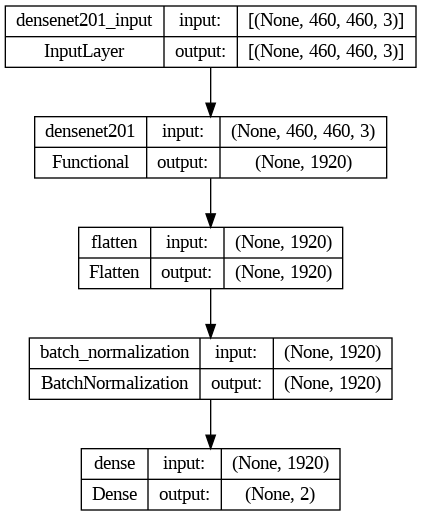

In [ ]:
# show schematic of model:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 10,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6169 - acc: 0.6594 
Epoch 1: val_loss improved from inf to 0.38998, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-DenseNet201.hdf5
10/10 [==============================] - 425s 41s/step - loss: 0.6169 - acc: 0.6594 - val_loss: 0.3900 - val_acc: 0.7937
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3208 - acc: 0.9031 
Epoch 2: val_loss improved from 0.38998 to 0.27484, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-DenseNet201.hdf5
10/10 [==============================] - 380s 38s/step - loss: 0.3208 - acc: 0.9031 - val_loss: 0.2748 - val_acc: 0.8571
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.9312 
Epoch 3: val_loss improved from 0.27484 to 0.19898, saving model to /content/gdrive/My Drive/SML_Project/chest_CT_SCAN-DenseNet201.hdf5
10/10 [==============================] - 417s 43s/step - loss: 0.2064 - acc: 0.9312 

In [ ]:
result = model.evaluate(test_generator)

9/9 [==============================] - 230s 25s/step - loss: 0.0616 - acc: 0.9928


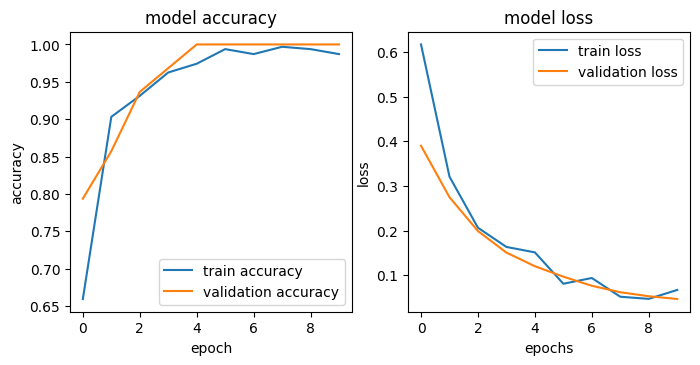

In [ ]:
# plt.plot(history_dense.history['acc'], label = 'train',)
# plt.plot(history_dense.history['val_acc'], label = 'val')

# plt.legend(loc = 'right')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.show()

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.plot(history_dense.history['acc'])
plt.plot(history_dense.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

### Serialize ResNet model

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/SML_Project/model_DenseNet.json","w") as json_file:
  json_file.write(model_json)

**Implement Lime**

In [ ]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=709e39a9155a9c6432e39c9ae9b11a120e2c899dd1afbb36ed5b35fa3b170a86
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

np.random.seed(123)

In [ ]:
IMG_SIZE = (460, 460)
def transform_image(img):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

In [ ]:
test_generator.class_indices

{'cancerous': 0, 'non_cancerous': 1}

In [ ]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    if model_prediction[0][0] > model_prediction[0][1] :
      print(f"The predicted class is : cancerous with probability - {model_prediction[0][0]}")
    else :
      print(f"The predicted class is : non cancerous with probability - {model_prediction[0][1]}")
    # return decode_predictions(model_prediction, top=1)[0][0][1]

In [ ]:
from skimage.segmentation import mark_boundaries

def masked_explaind_images(exp) :
  temp_1, mask_1 = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  temp_2, mask_2 = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
  ax1.imshow(mark_boundaries(temp_1, mask_1))
  ax2.imshow(mark_boundaries(temp_2, mask_2))
  ax1.axis('off')
  ax2.axis('off')

In [ ]:
explainer = lime_image.LimeImageExplainer()
def lime(path):
  img = image.load_img(path, target_size=IMG_SIZE)
  normalized_img = transform_image(img)

  plt.imshow(normalized_img[0])
  # pred_orig = get_model_predictions(normalized_img) 

  exp = explainer.explain_instance(normalized_img[0], 
                                  model.predict)
  masked_explaind_images(exp)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


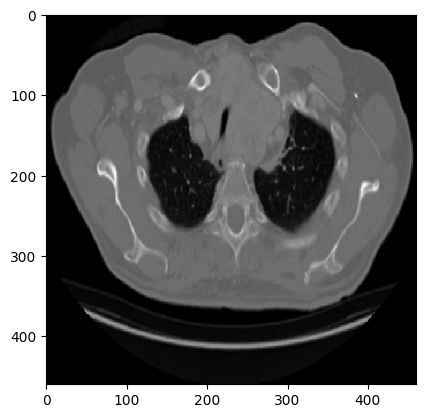

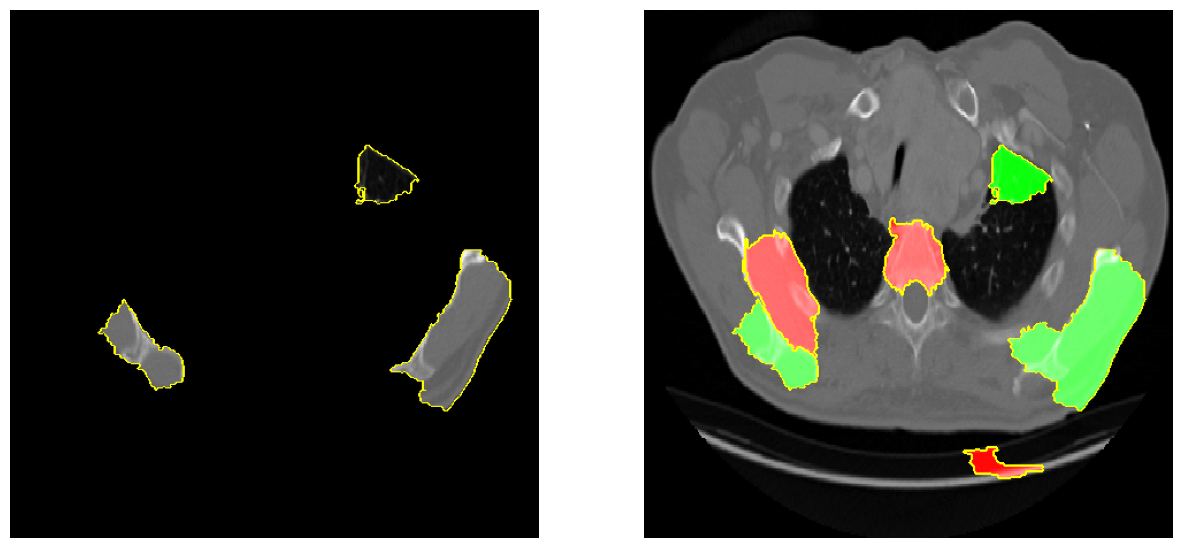

In [ ]:
image_paths = ["/content/ct_scan/test/cancerous/000108.png", "/content/ct_scan/test/non_cancerous/21.png"]

lime(image_paths[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


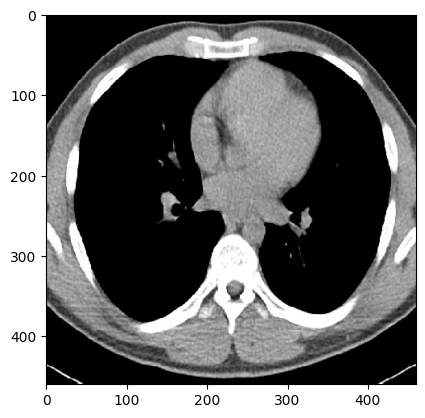

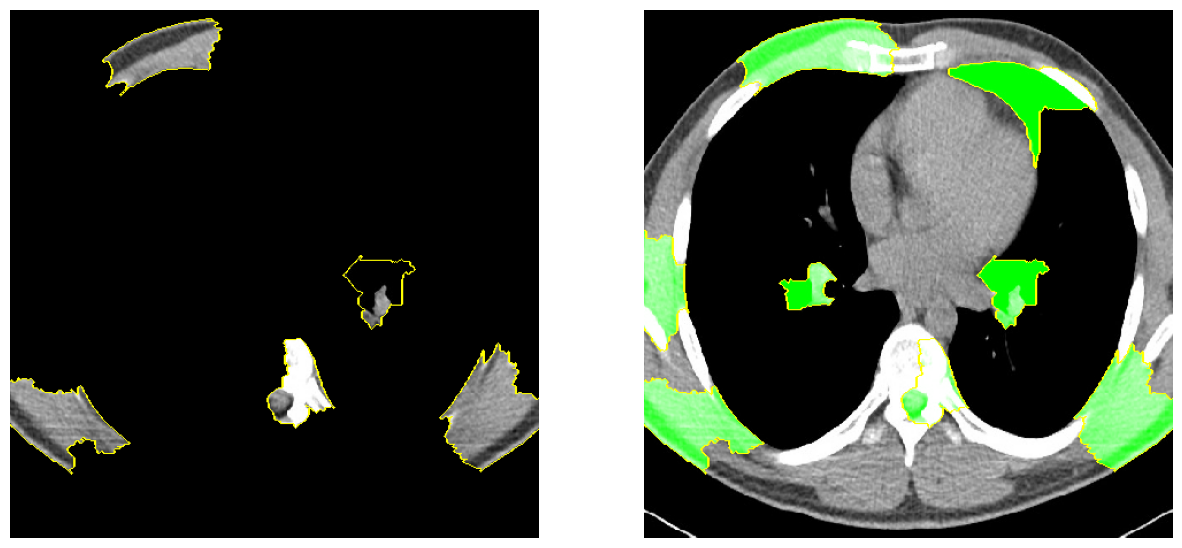

In [ ]:
lime(image_paths[1])